# Assignment 3

# Instructions

1. You have to use only this notebook for all your code.
2. All the results and plots should be mentioned in this notebook.
3. For final submission, submit this notebook along with the report ( usual 2-4 pages, latex typeset, which includes the challenges faces and details of additional steps, if any)
4. Marking scheme
    -  **60%**: Your code should be able to detect bounding boxes using resnet 18, correct data loading and preprocessing. Plot any 5 correct and 5 incorrect sample detections from the test set in this notebook for both the approached (1 layer and 2 layer detection), so total of 20 plots.
    -  **20%**: Use two layers (multi-scale feature maps) to detect objects independently as in SSD (https://arxiv.org/abs/1512.02325).  In this method, 1st detection will be through the last layer of Resnet18 and the 2nd detection could be through any layer before the last layer. SSD uses lower resolution layers to detect larger scale objects. 
    -  **20%**: Implement Non-maximum suppression (NMS) (should not be imported from any library) on the candidate bounding boxes.
    
5. Report AP for each of the three class and mAP score for the complete test set.

In [1]:
from __future__ import division, print_function, unicode_literals
import numpy as np
import torch
import torch.utils.data
import torchvision.transforms as transforms
from torch.autograd import Variable
import matplotlib.pyplot as plt

import os
import xml.etree.ElementTree as ET
from PIL import Image
from shutil import copyfile
from torchvision import datasets, models
import torch.nn as nn
import torch.optim as optim
import shutil

%matplotlib inline
plt.ion()
# Import other modules if required
# Can use other libraries as well

resnet_input = 224 #size of resnet18 input images

In [6]:
# Choose your hyper-parameters using validation data
batch_size = 32
epochs = 5
learning_rate =  0.005
hyp_momentum = 0.9

## Build the data
Use the following links to locally download the data:
<br/>Training and validation:
<br/>http://host.robots.ox.ac.uk/pascal/VOC/voc2007/VOCtrainval_06-Nov-2007.tar
<br/>Testing data:
<br/>http://host.robots.ox.ac.uk/pascal/VOC/voc2007/VOCtest_06-Nov-2007.tar
<br/>The dataset consists of images from 20 classes, with detection annotations included. The JPEGImages folder houses the images, and the Annotations folder has the object-wise labels for the objects in one xml file per image. You have to extract the object information, i.e. the [xmin, ymin] (the top left x,y co-ordinates) and the [xmax, ymax] (the bottom right x,y co-ordinates) of only the objects belonging to the three classes(aeroplane, bottle, chair). For parsing the xml file, you can import xml.etree.ElementTree for you. <br/>
<br/> Organize the data as follows:
<br/> For every image in the dataset, extract/crop the object patch from the image one by one using their respective co-ordinates:[xmin, ymin, xmax, ymax], resize the image to resnet_input, and store it with its class label information. Do the same for training/validation and test datasets. <br/>
##### Important
You also have to collect data for an extra background class which stands for the class of an object which is not a part of any of the 20 classes. For this, you can crop and resize any random patches from an image. A good idea is to extract patches that have low "intersection over union" with any object present in the image frame from the 20 Pascal VOC classes. The number of background images should be roughly around those of other class objects' images. Hence the total classes turn out to be four. This is important for applying the sliding window method later.


In [3]:
classes = ('__background__',
           'aeroplane',
           'bottle','chair'
           )

In [4]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "2"

In [5]:
k = 0
def intersection_over_union(orig_boxes,bg_boxes,img,file,count):
    global k
    for bg_box in bg_boxes:
        flag = 0
        for orig_box in orig_boxes:
            boxA = orig_box
            boxB = bg_box
            xA = max(boxA[0], boxB[0])
            yA = max(boxA[1], boxB[1])
            xB = min(boxA[2], boxB[2])
            yB = min(boxA[3], boxB[3])
 
            # compute the area of intersection rectangle
            interArea = max(0, xB - xA + 1) * max(0, yB - yA + 1)
 
            # compute the area of both the prediction and ground-truth
            # rectangles
            boxAArea = (boxA[2] - boxA[0] + 1) * (boxA[3] - boxA[1] + 1)
            boxBArea = (boxB[2] - boxB[0] + 1) * (boxB[3] - boxB[1] + 1)
 
            # compute the intersection over union by taking the intersection
            # area and dividing it by the sum of prediction + ground-truth
            # areas - the interesection area
            iou = float(interArea) / float(boxAArea + boxBArea - interArea)
#             if file.split('.')[0]=='003644':
#                     print(orig_box,bg_box,interArea,iou)
            if interArea > 0:
                flag=1
                break
#             if interArea==0 and k<700:
        if not flag and count%2:
            cropped_img = img.crop(bg_box)
            new_image_path = "data2/processed_data/{}/{}_{}".format('__background__', str(k), file.split('.')[0] + ".jpg")
            cropped_img.save(new_image_path)
            k+=1

In [6]:
# def build_dataset():
#     c=0
#     found_classes = {'__background__': 601}
#     processed_dir = 'data2/processed_data_test'
#     if os.path.exists(processed_dir):
#         shutil.rmtree(processed_dir)
#     os.makedirs(processed_dir)
#     data_path = "data2/testdata/Annotations/"
#     images_path = "data2/testdata/JPEGImages/"
    
#     for i in classes:
#         directory = "data2/processed_data_test/{}".format(i)
#         if not os.path.exists(directory):
#             os.makedirs(directory)
#     count = 0
#     for file in os.listdir(data_path):
#         flag = 0
#         f = open(data_path + file, "r").read()
#         xml = ET.fromstring(f)
#         objects = xml.findall('./object')
#         for obj in objects:
#             img_class = obj.find('name').text
#             if img_class in classes:
#                 c+=1
#                 if found_classes.get(img_class, None) is not None:
#                     found_classes[img_class] += 1
#                 else:
#                     found_classes[img_class] = 1
#                 box = obj.find('bndbox')
#                 xmin = int(box.find('xmin').text)
#                 ymin = int(box.find('ymin').text)
#                 ymax = int(box.find('ymax').text)
#                 xmax = int(box.find('xmax').text)
#                 image_path = images_path + file.split('.')[0] + ".jpg"
#                 img = Image.open(image_path)
#                 area = (xmin, ymin, xmax, ymax)
#                 cropped_img = img.crop(area)
#                 new_image_path = "data2/processed_data_test/{}/{}_{}".format(img_class, str(c), file.split('.')[0] + ".jpg")
#                 cropped_img.save(new_image_path)
#                 flag = 1
#         if not flag and count < 600:
#             image_path = images_path + file.split('.')[0] + ".jpg"
# #                 img = Image.open(image_path)
# #                 area = (xmin, ymin, xmax, ymax)
# #                 cropped_img = img.crop(area)
#             new_image_path = "data2/processed_data_test/{}/{}_{}".format(classes[0], str(c), file.split('.')[0] + ".jpg")
# #                 cropped_img.save(new_image_path)
#             copyfile(image_path, new_image_path)
#             count+=1
#     print(found_classes)

In [7]:
def build_dataset():
    c=0
    found_classes = {'__background__': 0}
    processed_dir = 'data2/processed_data'
    if os.path.exists(processed_dir):
        shutil.rmtree(processed_dir)
    os.makedirs(processed_dir)
    data_path = "data2/VOCdevkit/Annotations/"
    images_path = "data2/VOCdevkit/JPEGImages/"
    for i in classes:
        directory = "data2/processed_data/{}".format(i)
        if not os.path.exists(directory):
            os.makedirs(directory)
    count = 0
    for file in os.listdir(data_path):
        flag = 0
        f = open(data_path + file, "r").read()
        xml = ET.fromstring(f)
        objects = xml.findall('./object')
        boxes = []
        for obj in objects:
            img_class = obj.find('name').text
            if img_class in classes:
                c+=1
                if found_classes.get(img_class, None) is not None:
                    found_classes[img_class] += 1
                else:
                    found_classes[img_class] = 1
                box = obj.find('bndbox')
                xmin = int(box.find('xmin').text)
                ymin = int(box.find('ymin').text)
                ymax = int(box.find('ymax').text)
                xmax = int(box.find('xmax').text)
                image_path = images_path + file.split('.')[0] + ".jpg"
                img = Image.open(image_path)
                area = (xmin, ymin, xmax, ymax)
                cropped_img = img.crop(area)
                new_image_path = "data2/processed_data/{}/{}_{}".format(img_class, str(c), file.split('.')[0] + ".jpg")
                cropped_img.save(new_image_path)
                flag = 1
            box = obj.find('bndbox')
            xmin = int(box.find('xmin').text)
            ymin = int(box.find('ymin').text)
            ymax = int(box.find('ymax').text)
            xmax = int(box.find('xmax').text)
            coordinates = [xmin, ymin, xmax, ymax]
            boxes.append(coordinates)
        image_path = images_path + file.split('.')[0] + ".jpg"
        img = Image.open(image_path)
        width, height = img.size
        if width<224 or height<224:
            continue
        bg = []
#         coordinates = [0,0,224,224]
#         bg.append(coordinates)
#         coordinates = [width-224,0,width,224]
#         bg.append(coordinates)
#         coordinates = [0,height-224,224,height]
#         bg.append(coordinates)
#         coordinates = [width-224,height-224,width,height]
#         bg.append(coordinates)
        coordinates = [0,0,100,100]
        bg.append(coordinates)
        coordinates = [width-100,0,width,100]
        bg.append(coordinates)
        coordinates = [0,height-100,100,height]
        bg.append(coordinates)
        coordinates = [width-100,height-100,width,height]
        bg.append(coordinates)
        coordinates = [int(width/2)-20,height-70,int(width/2)+20,height]
        bg.append(coordinates)
        coordinates = [int(width/2)-20,0,int(width/2)+20,70]
        bg.append(coordinates)
        coordinates = [0,int(height/2)-20,70,int(height/2)+20]
        bg.append(coordinates)
        coordinates = [0,int(height/2)-20,70,int(height/2)+20]
        bg.append(coordinates)
        coordinates = [width-70,int(height/2)-20,width,int(height/2)+20]
        bg.append(coordinates)
        intersection_over_union(boxes,bg,img,file,count)
        count+=1
#         if not flag and count < 600:
#             image_path = images_path + file.split('.')[0] + ".jpg"
# #                 img = Image.open(image_path)
# #                 area = (xmin, ymin, xmax, ymax)
# #                 cropped_img = img.crop(area)
#             new_image_path = "data2/processed_data/{}/{}_{}".format(classes[0], str(c), file.split('.')[0] + ".jpg")
# #                 cropped_img.save(new_image_path)
#             copyfile(image_path, new_image_path)
#             count+=1
    found_classes['__background__'] = k
    print(found_classes)

In [8]:
build_dataset()

{'__background__': 10035, 'chair': 1432, 'aeroplane': 331, 'bottle': 634}


In [8]:
data_dir = 'data2/processed_data/'
def load_split_train_test(datadir, valid_size = .05):
    train_transforms = transforms.Compose([transforms.Resize([resnet_input,resnet_input]),
                                       transforms.ToTensor(),
                                       ])
    test_transforms = transforms.Compose([transforms.Resize([resnet_input,resnet_input]),
                                      transforms.ToTensor(),
                                      ])
    train_data = datasets.ImageFolder(datadir,       
                    transform=train_transforms)
    test_data = datasets.ImageFolder(datadir,
                    transform=test_transforms)
    num_train = len(train_data)
    print(num_train)
    indices = list(range(num_train))
    split = int(np.floor(valid_size * num_train))
    np.random.shuffle(indices)
    from torch.utils.data.sampler import SubsetRandomSampler
    train_idx, test_idx = indices[split:], indices[:split]
    train_sampler = SubsetRandomSampler(train_idx)
    test_sampler = SubsetRandomSampler(test_idx)
    trainloader = torch.utils.data.DataLoader(train_data,
                   sampler=train_sampler, batch_size=batch_size)
    testloader = torch.utils.data.DataLoader(test_data,
                   sampler=test_sampler, batch_size=batch_size)
    return trainloader, testloader
trainloader, testloader = load_split_train_test(data_dir, .1)
# print(trainloader.dataset.)
print(trainloader.dataset.classes)

3066
['__background__', 'aeroplane', 'bottle', 'chair']


In [ ]:
# class voc_dataset(torch.utils.data.Dataset): # Extend PyTorch's Dataset class
#     def __init__(self, root_dir, train, transform=None):
#         # Begin
        
#     def __len__(self):
#         # Begin
        
#     def __getitem__(self, idx):
#        # Begin
    

## Train the netwok
<br/>You can train the network on the created dataset. This will yield a classification network on the 4 classes of the VOC dataset. 

In [ ]:
# composed_transform = transforms.Compose([transforms.Scale((resnet_input,resnet_input)),
#                                          transforms.ToTensor(),
#                                          transforms.RandomHorizontalFlip()])
# train_dataset = voc_dataset(root_dir='', train=True, transform=composed_transform) # Supply proper root_dir
# test_dataset = voc_dataset(root_dir='', train=False, transform=composed_transform) # Supply proper root_dir

# train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
# test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

### Fine-tuning
Use the pre-trained network to fine-tune the network in the following section:

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() 
                                  else "cpu")
model = models.resnet18(pretrained=True)
                                 
for param in model.parameters():
    param.requires_grad = False

# model.classifier = nn.Sequential(nn.Linear(25088, 512),
# #                                  nn.LogSoftmax(dim=1))
#                                  nn.ReLU(),
#                                  nn.Dropout(0.2),
#                                  nn.Linear(512, 5),
#                                  nn.LogSoftmax(dim=1))
model.fc = nn.Sequential(nn.Linear(model.fc.in_features, 2048),
                         nn.ReLU(),
                         nn.Dropout(0.2),
                        nn.Linear(2048, 512),
                        nn.ReLU(),
                         nn.Dropout(0.2),
                                 nn.Linear(512, 4),
                                 nn.LogSoftmax(dim=1)
)

# model.classifier = nn.Sequential(nn.Linear(25088, 4),
#                                  nn.LogSoftmax(dim=1))
# Add code for using CUDA here

In [8]:
criterion = nn.CrossEntropyLoss()
# criterion = nn.NLLLoss()
# Update if any errors occur
# optimizer = optim.SGD(model.parameters(), learning_rate, hyp_momentum)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Co

In [11]:
#One Layer Detection
def train():
#     epochs = 3
    steps = 0
    running_loss = 0
    print_every = 20
    train_losses, test_losses = [], []
    for epoch in range(epochs):
        for inputs, labels in trainloader:
            steps += 1
            inputs, labels = inputs.to(device),labels.to(device)
            optimizer.zero_grad()
            logps = model.forward(inputs)
            loss = criterion(logps, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
      
            if steps % print_every == 0:
                test_loss = 0
                accuracy = 0
                model.eval()
                with torch.no_grad():
                    for inputs, labels in testloader:
                        inputs, labels = inputs.to(device), labels.to(device)
                        logps = model.forward(inputs)
                        batch_loss = criterion(logps, labels)
                        test_loss += batch_loss.item()
                        ps = torch.exp(logps)
                        top_p, top_class = ps.topk(1, dim=1)
                        equals = top_class == labels.view(*top_class.shape)
                        accuracy += torch.mean(equals.type(torch.FloatTensor)).item()
                train_losses.append(running_loss/len(trainloader))
                test_losses.append(test_loss/len(testloader))                    
                print(f"Epoch {epoch+1}/{epochs}.. "
                      f"Train loss : {running_loss/print_every:.3f}.. "
                      f"Test loss: {test_loss/len(testloader):.3f}.. "
                      f"Test accuracy: {accuracy/len(testloader):.3f}")
                acc = accuracy/len(testloader)
                if acc >= 0.99:
                    torch.save(model, 'models/resnet18.pth')
                running_loss = 0
                model.train()
    torch.save(model, 'models/resnet18.pth')

In [12]:
# model = torch.load('models/resnet18.pth')

In [13]:
%time train()

Epoch 1/5.. Train loss : 2.897.. Test loss: 0.652.. Test accuracy: 0.873
Epoch 1/5.. Train loss : 0.584.. Test loss: 0.329.. Test accuracy: 0.893
Epoch 1/5.. Train loss : 0.367.. Test loss: 0.286.. Test accuracy: 0.911
Epoch 1/5.. Train loss : 0.299.. Test loss: 0.270.. Test accuracy: 0.925
Epoch 2/5.. Train loss : 0.195.. Test loss: 0.187.. Test accuracy: 0.928
Epoch 2/5.. Train loss : 0.124.. Test loss: 0.272.. Test accuracy: 0.922
Epoch 2/5.. Train loss : 0.152.. Test loss: 0.291.. Test accuracy: 0.916
Epoch 2/5.. Train loss : 0.102.. Test loss: 0.213.. Test accuracy: 0.953
Epoch 3/5.. Train loss : 0.099.. Test loss: 0.338.. Test accuracy: 0.924
Epoch 3/5.. Train loss : 0.070.. Test loss: 0.292.. Test accuracy: 0.936
Epoch 3/5.. Train loss : 0.069.. Test loss: 0.365.. Test accuracy: 0.926
Epoch 3/5.. Train loss : 0.052.. Test loss: 0.293.. Test accuracy: 0.933
Epoch 3/5.. Train loss : 0.052.. Test loss: 0.183.. Test accuracy: 0.951
Epoch 4/5.. Train loss : 0.049.. Test loss: 0.235..

In [14]:
# #Two Layer Detection (SSD)
# def train():
    
#     # Begin

In [15]:
# %time train()

# Testing and Accuracy Calculation
For applying detection, use a slding window method to test the above trained trained network on the detection task:<br/>
Take some windows of varying size and aspect ratios and slide it through the test image (considering some stride of pixels) from left to right, and top to bottom, detect the class scores for each of the window, and keep only those which are above a certain threshold value. There is a similar approach used in the paper -Faster RCNN by Ross Girshick, where he uses three diferent scales/sizes and three different aspect ratios, making a total of nine windows per pixel to slide. You need to write the code and use it in testing code to find the predicted boxes and their classes.

In [16]:
def sliding_window(image, windowSize, stepSize):
    for y in range(0, image.shape[0], stepSize):
        for x in range(0, image.shape[1], stepSize):
                yield (x, y, image[y:y + windowSize[0], x:x + windowSize[1]])

In [17]:
# image = Image.open("data2/000260.jpg")
# image

In [18]:
# image = np.array(Image.open("data2/000260.jpg"))
# image = image[0:70, 0:40]
# im = Image.fromarray(image)
# im

In [19]:
test_transforms = transforms.Compose([transforms.Resize([resnet_input,resnet_input]),
                                      transforms.ToTensor()])
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
def predict_image(image):
    image_tensor = test_transforms(image).float()
    image_tensor = image_tensor.unsqueeze_(0)
    inputa = Variable(image_tensor)
    inputa = inputa.to(device)
    output = model(inputa)
#     output = model.forward(inputa)
    output = torch.exp(output)
#     top_p, top_class = output.topk(1, dim=1)
    return output
#     return output,top_p,top_class
#     index = output.data.cpu().numpy().argmax()
#     print(index)
#     re

In [20]:
# for i in os.listdir("data2/processed_data/aeroplane/"):
#     image = Image.open("data2/processed_data/aeroplane/" + i)
# #     output,top_p,top_class = predict_image(image)
#     output = predict_image(image)
#     print(output.data.cpu().numpy().argmax(), output.data.cpu().numpy().max())
# #     print()
# # 

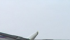

In [21]:
image = Image.open("data2/000260.jpg")
test_transforms2 = transforms.Compose([transforms.Resize([resnet_input,resnet_input]),
                                          transforms.ToTensor(), transforms.ToPILImage(mode=None)])
image = test_transforms2(image)
image = image.crop((133, 0, 203, 40))
image

In [22]:
# image = Image.open("data2/000260.jpg")
# image = image.crop((133, 0, 203, 40))
output = predict_image(image)
print(output.data.cpu().numpy().argmax(), output.data.cpu().numpy().max())
# #     print()

0 0.9996963


In [23]:
def test_image(image_path, model):
#     x = Image.open('data/VOCdevkit/JPEGImages/002847.jpg')
    x = Image.open(image_path)
    test_transforms = transforms.Compose([transforms.Resize([resnet_input,resnet_input]),
                                          transforms.ToTensor(), transforms.ToPILImage(mode=None)])
    image = test_transforms(x)
    np_image = np.array(image)
    windowSize = [(40, 70), (70, 40), (40, 40), (100, 150), (150, 100),
                  (100, 100), (180, 200), (200, 180), (180, 180)]
#     windowSize = [(150,150)]
    z = []
    for i in windowSize:
        for (x, y, window) in sliding_window(np_image, i, 7):
            if window.shape[0] != i[0] or window.shape[1] != i[1]:
                continue
            else:
                xa = x
                ya = y
                xb = x + i[1]
                yb = y + i[0]
#                 if((xa, ya, xb, yb) == (133, 0, 203, 40)):
#                     fig,ax = plt.subplots(1)
#                     ax.imshow(window)
#                     plt.show()
                im = Image.fromarray(window)
                z.append((im, (xa, ya, xb, yb)))
    print("Total predictions ", len(z))
    boxes = []
    for img in z:
#         image = Image.open(i)
        output = predict_image(img[0])
        score = output.data.cpu().numpy().max()
        index = output.data.cpu().numpy().argmax()
#         score = output[index]
        cl = classes[index]
        boxes.append((img[1], cl, score))
#         if img[1]==(133, 0, 203, 40):
#             print(cl,score)
    return boxes

In [24]:
# test_image("dsd", model)

In [25]:
def iou(boxA,boxB):
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[2], boxB[2])
    yB = min(boxA[3], boxB[3])

    interArea = max(0, xB - xA + 1) * max(0, yB - yA + 1)

    boxAArea = (boxA[2] - boxA[0] + 1) * (boxA[3] - boxA[1] + 1)
    boxBArea = (boxB[2] - boxB[0] + 1) * (boxB[3] - boxB[1] + 1)

    iou_ = float(interArea) / float(boxAArea + boxBArea - interArea)
    return iou_

In [ ]:
def nms(boxes,bounding_box):
   
    return new_boxes,bounding_box

In [44]:
def non_maximum_supression(boxes,threshold = 0.3):
    print("Starting non max supression..")
    
    c = {}
    for i in boxes:
        if i[1] in c:
            c[i[1]] +=1
        else:
            c[i[1]] = 1

    my_class = None
    count = -1
    for i, j in c.items():
        if j > count and i != "__background__":
            my_class = i
            count = j
    new_boxes = []
    for i in boxes:
        if i[1] == my_class:
            new_boxes.append(i)
    boxes = new_boxes
    bounding_box = []
    count=0
    count2 = 0
    flag = [0]*len(boxes)
    while(count<len(boxes)):
        max_score = -99999999
        best_box = []
        for i,box1 in enumerate(boxes):
            for j,box2 in enumerate(boxes):
                if (flag[i]==0 or flag[j]==0) and iou(box1[0],box2[0])>threshold:
                    if flag[i] == 0:
                        count += 1
                    if flag[j] == 0:
                        count += 1
                    flag[i] = 1
                    flag[j] = 1
                    if max_score<max(box1[2],box2[2]):
                        max_score = max(box1[2],box2[2])
                        if box1[2]>box2[2]:
                            best_box = box1
                        elif box1[2]<box2[2]:
                            best_box = box2
                        else:
                            area_box1 = (box1[0][2] - box1[0][0] + 1) * (box1[0][3] - box1[0][1] + 1)
                            area_box2 = (box2[0][2] - box2[0][0] + 1) * (box2[0][3] - box2[0][1] + 1)
                            if area_box1>area_box2:
                                best_box = box1
                            else:
                                best_box = box2
                    elif max_score==box1[2]:
                        area_box1 = (box1[0][2] - box1[0][0] + 1) * (box1[0][3] - box1[0][1] + 1)
                        area_best_box = (best_box[0][2] - best_box[0][0] + 1) * (best_box[0][3] - best_box[0][1] + 1)
                        if area_box1>area_best_box:
                                best_box = box1
                    elif max_score==box2[2]:
                        area_box2 = (box2[0][2] - box2[0][0] + 1) * (box2[0][3] - box2[0][1] + 1)
                        area_best_box = (best_box[0][2] - best_box[0][0] + 1) * (best_box[0][3] - best_box[0][1] + 1)
                        if area_box2>area_best_box:
                                best_box = box2

        bounding_box.append(best_box)
        count2+=1
        if count2 == len(boxes):
            break
            
#         for i,box in enumerate(boxes):
#             if(flag[i]==0):
#                 new_box.append(box)
    return bounding_box

In [55]:
def test(model):
    test_results = {}
#     data_path = "data/testdata/Annotations/"
    data_path = "data2/mytest/"
    image_path = "data2/testdata/JPEGImages/"
    for file in os.listdir(data_path):
        if file.split(".")[0] != "007837":
            continue
        flag = 0
        f = open(data_path + file, "r").read()
        xml = ET.fromstring(f)
        objects = xml.findall('./object')
        for obj in objects:
            img_class = obj.find('name').text
            if img_class in classes:
                test_image_path = image_path + file.split(".")[0] + ".jpg"
                boxes = test_image(test_image_path, model)
#                 boxes = non_maximum_supression(boxes, 0.9)
                print(file.split(".")[0] + ".jpg", boxes)
                test_results[file.split(".")[0] + ".jpg"] = boxes
                flag = 1
                break
        
    return test_results

In [56]:
%time results = test(model)

Total predictions  2796
007837.jpg [((0, 0, 70, 40), '__background__', 0.9984177), ((7, 0, 77, 40), '__background__', 0.99999523), ((14, 0, 84, 40), '__background__', 0.99995136), ((21, 0, 91, 40), '__background__', 0.9999714), ((28, 0, 98, 40), '__background__', 0.99999523), ((35, 0, 105, 40), '__background__', 0.997996), ((42, 0, 112, 40), '__background__', 0.999876), ((49, 0, 119, 40), '__background__', 0.99998564), ((56, 0, 126, 40), '__background__', 0.99996185), ((63, 0, 133, 40), '__background__', 0.99971396), ((70, 0, 140, 40), '__background__', 0.99999183), ((77, 0, 147, 40), '__background__', 0.9788941), ((84, 0, 154, 40), '__background__', 0.9993236), ((91, 0, 161, 40), '__background__', 0.9999018), ((98, 0, 168, 40), '__background__', 0.99703467), ((105, 0, 175, 40), '__background__', 0.99996275), ((112, 0, 182, 40), '__background__', 0.9999961), ((119, 0, 189, 40), '__background__', 0.99997425), ((126, 0, 196, 40), '__background__', 0.9998746), ((133, 0, 203, 40), '__backg

In [57]:
results

{'007837.jpg': [((0, 0, 70, 40), '__background__', 0.9984177),
  ((7, 0, 77, 40), '__background__', 0.99999523),
  ((14, 0, 84, 40), '__background__', 0.99995136),
  ((21, 0, 91, 40), '__background__', 0.9999714),
  ((28, 0, 98, 40), '__background__', 0.99999523),
  ((35, 0, 105, 40), '__background__', 0.997996),
  ((42, 0, 112, 40), '__background__', 0.999876),
  ((49, 0, 119, 40), '__background__', 0.99998564),
  ((56, 0, 126, 40), '__background__', 0.99996185),
  ((63, 0, 133, 40), '__background__', 0.99971396),
  ((70, 0, 140, 40), '__background__', 0.99999183),
  ((77, 0, 147, 40), '__background__', 0.9788941),
  ((84, 0, 154, 40), '__background__', 0.9993236),
  ((91, 0, 161, 40), '__background__', 0.9999018),
  ((98, 0, 168, 40), '__background__', 0.99703467),
  ((105, 0, 175, 40), '__background__', 0.99996275),
  ((112, 0, 182, 40), '__background__', 0.9999961),
  ((119, 0, 189, 40), '__background__', 0.99997425),
  ((126, 0, 196, 40), '__background__', 0.9998746),
  ((133, 0, 

In [50]:
for i in results['000260.jpg']:
    print(i)

((0, 0, 200, 180), 'aeroplane', 1.0)


In [58]:
c = {}
for i in results['007837.jpg']:
    if i[1] in c:
        c[i[1]] +=1
    else:
        c[i[1]] = 1

my_class = None
count = -1
for i, j in c.items():
    if j > count and i != "__background__":
        my_class = i
        count = j
my_class

'bottle'

Apply non_maximum_supression to reduce the number of boxes. You are free to choose the threshold value for non maximum supression, but choose wisely [0,1].

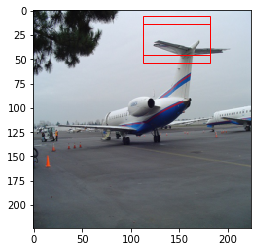

In [3]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
# from PIL import Image
# import numpy as np


x = Image.open('data/testdata/JPEGImages/000260.jpg')
test_transforms = transforms.Compose([transforms.Resize([resnet_input,resnet_input]),
                                          transforms.ToTensor(), transforms.ToPILImage(mode=None)])
image = test_transforms(x)
im = np.array(image, dtype=np.uint8)
# Create figure and axes
fig,ax = plt.subplots(1)

# Display the image
ax.imshow(im)

# Create a Rectangle patch
rect = patches.Rectangle((112,14),70,40,linewidth=1,edgecolor='r',facecolor='none')

# Add the patch to the Axes
ax.add_patch(rect)
rect = patches.Rectangle((112,5),70,40,linewidth=1,edgecolor='r',facecolor='none')
ax.add_patch(rect)

plt.show()

Test the trained model on the test dataset.

In [ ]:
#One Layer Detection
def test(resnet18):
    # Write loops for testing the model on the test set
    # Also print out the accuracy of the model

In [ ]:
%time test(resnet18)

In [ ]:
#Two Layer Detection
def test(resnet18):
    # Write loops for testing the model on the test set
    # Also print out the accuracy of the model

In [ ]:
%time test(resnet18)